# Flow cytometry of rate of IFN+ cells with reporter

This notebook re-plots Alistair's experiment in which his A549 IFNL1 reporter cells were infected with influenza virus, nothing (negative control), or Sendai virus (positive control) to assess the rate of IFN induction.

Load Python packages:

In [1]:
import itertools

import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY as PALETTE
from dms_tools2.ipython_utils import showPDF

Define plotting grid:

In [2]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

Read data for all replicates and conditions, putting HA and IFN on log scale:

In [3]:
conditions = {'Uninfected':'Uninfected', 'Sendai':'Sendai', '10xpop':'Influenza'}

replicates = [1, 2, 3]

flow_data = (
    pandas.concat(
        [pandas.read_csv(f'2018-09-07_flow_data/Specimen_001_{c}_{r}.csv')
               .assign(condition=conditions[c], replicate=r)
                for c in conditions.keys() for r in replicates]
        )
    .rename(columns={'FITC-A':'IFN', 'APC-A':'HA'})
    # set <= values to smallest > 0 value
    .assign(minHA=lambda x: x.query('HA > 0').HA.min(),
            HA=lambda x: np.where(x.HA < x.minHA, x.minHA, x.HA),
            minIFN=lambda x: x.query('IFN > 0').IFN.min(),
            IFN=lambda x: np.where(x.IFN < x.minIFN, x.minIFN, x.IFN))
    .assign(HA=lambda x: np.log10(x.HA),
            IFN=lambda x: np.log10(x.IFN))
    )

Set gates of 99.95th percentile for HA and IFN populations:

In [4]:
gate_threshold = 0.9995

threshold_HA = flow_data.query('condition == "Uninfected"').HA.quantile(gate_threshold)
threshold_IFN = flow_data.query('condition == "Uninfected"').IFN.quantile(gate_threshold)

flow_data = (
    flow_data
    .assign(HApos=lambda x: x.HA > threshold_HA,
            IFNpos=lambda x: x.IFN > threshold_IFN)
    )

Make the plot, also computing percentages in the four HA+/- and IFN+/- quadrants along the way:

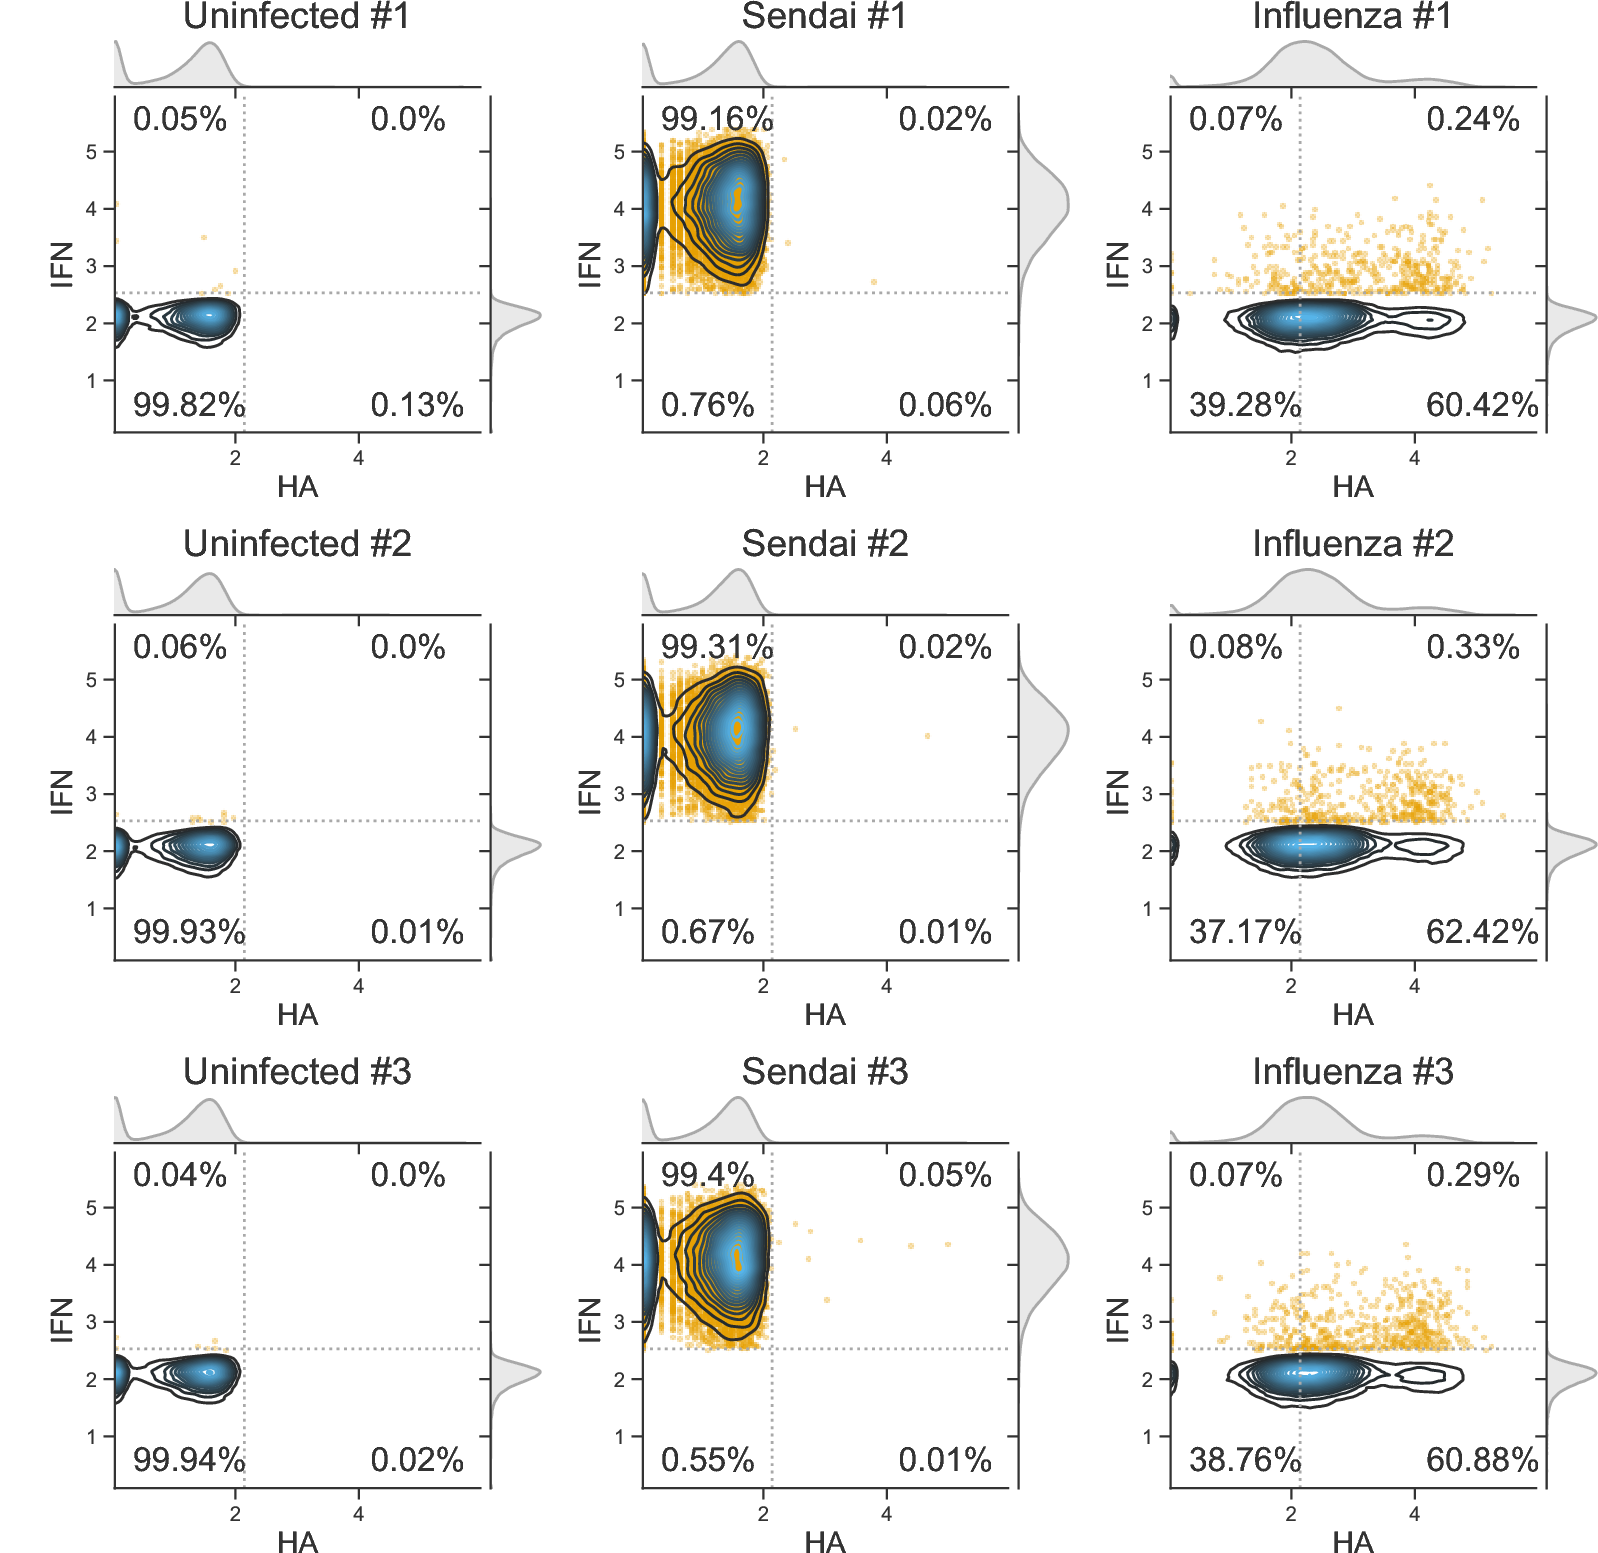

In [5]:
sns.set()
sns.set_style("white")
sns.set_style("ticks")

percents = []

gs = gridspec.GridSpec(len(replicates), len(conditions), )
fig = plt.figure(figsize=(4 * len(replicates), 4 * len(conditions)))

for i, (replicate, condition) in enumerate(itertools.product(replicates, conditions.values())):

    idata = flow_data.query("condition == @condition & replicate == @replicate")
    g = (
        sns.JointGrid(x='HA', y='IFN', data=idata,
                      xlim=(flow_data.HA.min(), 1.1 * flow_data.HA.max()),
                      ylim=(flow_data.IFN.min(), 1.1 * flow_data.IFN.max()))
        .plot_joint(sns.kdeplot, n_levels=20, color=PALETTE[2])
        .plot_marginals(sns.kdeplot, shade=True, color=PALETTE[0])
        )
    ax = g.ax_joint
    sns.regplot(x='HA', y='IFN', data=idata.query('IFNpos'), color=PALETTE[1],
                ax=ax, scatter_kws={'s':5, 'alpha':0.3, 'rasterized':True},
                fit_reg=False)
    ax.axvline(x=threshold_HA, c=PALETTE[0], ls=':')
    ax.axhline(y=threshold_IFN, c=PALETTE[0], ls=':')
    
    n = len(idata) / 100.0 # divide by 100 to get percents
    HAnegIFNneg = len(idata.query('~HApos & ~IFNpos')) / n
    HAposIFNpos = len(idata.query('HApos & IFNpos')) / n
    HAposIFNneg = len(idata.query('HApos & ~IFNpos')) / n
    HAnegIFNpos = len(idata.query('~HApos & IFNpos')) / n
    percents.append((condition, replicate, HAnegIFNneg, HAposIFNpos, HAposIFNneg, HAnegIFNpos))
    ax.text(0.05, 0.05, str(round(HAnegIFNneg, 2)) + '%', transform=ax.transAxes, fontsize=18)
    ax.text(0.05, 0.9, str(round(HAnegIFNpos, 2)) + '%', transform=ax.transAxes, fontsize=18)
    ax.text(0.7, 0.05, str(round(HAposIFNneg, 2)) + '%', transform=ax.transAxes, fontsize=18)
    ax.text(0.7, 0.9, str(round(HAposIFNpos, 2)) + '%', transform=ax.transAxes, fontsize=18)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
        
    SeabornFig2Grid(g, fig, gs[i])
    
    fig.get_axes()[1 + 3 * i].set_title(f'{condition} #{replicate}', fontsize=20)
    
gs.tight_layout(fig)

plotfile = 'flow_plot.pdf'
fig.savefig(plotfile)
showPDF(plotfile, width=500)

plt.close()

Calculate and write to CSV file the statistic on the percent of cells IFN+.

For the influenza-infected cells, we calculate IFN+ percentage only among HA+ cells, as they are the only ones that we consider to be infected.
For the Sendai and Uninfected we simply calculate the total IFN+ cell percentage, since there is no meaningful staining for HA and since all cells are infected with Sendai (we used high dose) and no cells are infected for Uninfected.

In [6]:
ifn_stats = (
    pandas.DataFrame(
        percents,
        columns=['condition', 'replicate', 'HAnegIFNneg',
                 'HAposIFNpos', 'HAposIFNneg', 'HAnegIFNpos']
        )
    .assign(IFNpercent=lambda x: np.where(
        x.condition == 'Influenza',
        100 * x.HAposIFNpos / (x.HAposIFNpos + x.HAposIFNneg),
        x.HAposIFNpos + x.HAnegIFNpos)
        )
    )

ifn_stats

ifn_stats.to_csv('ifn_stats.csv', index=False)